In [6]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pandas as pd
import json
import numpy as np

### vauth

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    logical_cpus = tf.config.experimental.list_logical_devices('CPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    print(len(cpus), "Physical CPUs,", len(logical_cpus), "Logical CPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs
1 Physical CPUs, 1 Logical CPUs


In [4]:
from google.colab import auth
auth.authenticate_user()


# preprosessing

## extract features from files and make a dataframe

In [11]:
#help function to import data as dataframes
def import_to_df(folder, start, end): 
  
  #preprosess filenames
  filenamessorted = []
  for filename in os.listdir(folder):
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
        try: 
          entry = json.loads(f.readline())
          filenamessorted.append((filename,entry['timestamp']))
        except:
          continue
  filenamessorted.sort(key=lambda a: a[1])
  files = [t[0] for t in filenamessorted]
  filessliced = files[start:end]
 
  print(filessliced)

  data = []
  errors = 0
  for filename in filessliced:
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)
  #print(df.head())
  return df


## import train

In [ ]:
# ---- real call:
#train_df = import_to_df("/content/normal",17,40);

# ---- testing calls:
train_df = import_to_df("/content/normal",17,40);
#train_df = train_df.iloc[:10000]


train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], utc=True)
# set timestamp as the index
train_df.set_index('timestamp', inplace=True)
# Sort the DataFrame by the index 
train_df = train_df.sort_index()


#catergorize latency
train_df['latency'] = (train_df['latency'] < 0.1).astype(int)

train_dforiginal = train_df.copy()

['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022', 'data000000000024', 'data000000000023', 'data000000000025', 'data000000000031', 'data000000000026', 'data000000000027', 'data000000000028', 'data000000000029', 'data000000000030', 'data000000000032', 'data000000000033', 'data000000000034', 'data000000000035', 'data000000000036', 'data000000000037', 'data000000000038', 'data000000000039', 'data000000000040']
Number of errors: 0


## import test

In [26]:
# ---- real call:
#test_df = import_to_df("/content/anomaly",39, 50);

# ---- testing calls:
test_df = import_to_df("/content/anomaly",39,50);
#test_df = test_df.iloc[:10000]
# set timestamp as the index

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], utc=True)

test_df.set_index('timestamp', inplace=True)

# Sort the DataFrame by the index 

test_df = test_df.sort_index()


#catergorize latency
test_df['latency'] = (test_df['latency'] < 0.1).astype(int)

test_dforiginal = test_df.copy()

['data-000000000030']
Number of errors: 0


## backup and debugging

In [12]:
print(train_dforiginal.shape, len(train_df))
print(test_dforiginal.shape, len(test_df))


(10000, 7) 10000
(10000, 7) 10000


In [ ]:
earliest_train = train_df.index.min()
latest_train = train_df.index.max()
earliest_test = test_df.index.min()
latest_test = test_df.index.max()

print("Earliest train timestamp:", earliest_train)
print("Latest train timestamp:", latest_train)
print("Earliest test timestamp:", earliest_test)
print("Latest test timestamp:", latest_test)


Earliest train timestamp: 2023-04-18 00:28:36.741168+00:00
Latest train timestamp: 2023-04-18 00:57:39.686390+00:00
Earliest test timestamp: 2023-04-21 00:07:40.949091+00:00
Latest test timestamp: 2023-04-21 01:07:49.241144+00:00


In [ ]:
# in case of error
train_df = train_dforiginal
test_df = test_dforiginal

print(train_df.head)
print(test_df.head)

In [ ]:
# assuming the dataframe is named 'df'
num_combinations = train_df.drop_duplicates().shape[0]
print(num_combinations)

311


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Tue May  9 11:16:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |    691MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## create keyes and dummies

In [27]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])


# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]

In [28]:
print(train_df.shape)
print(test_df.shape)
print(test_df.head())

(288197, 390)
(50085, 390)
                                  key_0  key_1  key_2  key_3  key_4  key_5  \
timestamp                                                                    
2023-04-21 13:45:23.881087+00:00      0      0      0      0      0      0   
2023-04-21 13:45:23.981462+00:00      0      0      0      0      0      0   
2023-04-21 13:45:23.985172+00:00      0      0      0      0      0      0   
2023-04-21 13:45:24.037875+00:00      0      0      0      0      0      0   
2023-04-21 13:45:24.173113+00:00      0      0      0      0      0      0   

                                  key_6  key_7  key_8  key_9  ...  key_380  \
timestamp                                                     ...            
2023-04-21 13:45:23.881087+00:00      0      0      0      0  ...        0   
2023-04-21 13:45:23.981462+00:00      0      0      0      0  ...        0   
2023-04-21 13:45:23.985172+00:00      0      0      0      0  ...        0   
2023-04-21 13:45:24.037875+00:00    

# AUTOENCODER

In [18]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from torch import nn, optim, device
import torch.nn.functional as F


class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [23]:
seq_len, n_features

(2, 259)

In [22]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

TypeError: ignored

## Datasets

### Function

In [15]:
import torch

def create_dataset(df, sequence_length):
    dataset = []
    for i in range(0, len(df), sequence_length):
        sequence = df.iloc[i:i+sequence_length]
        dataset.append(sequence.values.tolist())
    tensor_sequences = [torch.tensor(seq) for seq in dataset]
    n_seq, seq_len, n_features = torch.stack(tensor_sequences).shape
    return tensor_sequences, seq_len, n_features


### Creation

In [16]:
seq_len = 2
train_dataset, seq_len, n_features= create_dataset(train_df,seq_len)
#val_dataset, _, _ = create_dataset(val_df)
#test_normal_dataset, _, _ = create_dataset(test_df) #what is this test_df
test_anomaly_dataset, _, _ = create_dataset(test_df,seq_len)
print(train_dataset[0], n_features)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
train_dataset[:10]

[tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0,

# ML

##variables

In [29]:
# helper function for lstm autoencoder to recreate a timeseries

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [30]:
#defaults for training

timeseries = np.array(train_df.values)
timesteps = 10

X_train, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
n_features = timeseries.shape[1]


X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)

latent_dim = 3
batch_size = 32
epochs = 10

## gpu test

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## define model

In [31]:
import keras
from keras.models import Sequential
from keras.layers import LSTM


# Define the model 

model = tf.keras.Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 128)           265728    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_7 (LSTM)               (None, 10, 128)           98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 390)          50310     
 tributed)                                            

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
import tensorflow as tf

# Define the model 
with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential()
  model.add(LSTM(128, activation='tanh', input_shape=(timesteps,n_features), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(RepeatVector(timesteps))
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  model.summary()
# Write LaTeX table to file
with open('modelsummary.tex', 'w') as f:
    f.write(str(model.summary()))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           271872    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 20, 402)          51858     
 ibuted)                                                

### print

In [ ]:
import tabulate
table = tabulate.tabulate([['Layer (type)', 'Output Shape', 'Param #'],
                           *[(layer.name, layer.output_shape, layer.count_params()) for layer in model.layers]],
                          headers='firstrow', tablefmt='latex_booktabs')
print(table)



\begin{tabular}{llr}
\toprule
 Layer (type)     & Output Shape    &   Param \# \\
\midrule
 lstm             & (None, 20, 128) &    271872 \\
 lstm\_1           & (None, 64)      &     49408 \\
 repeat\_vector    & (None, 20, 64)  &         0 \\
 lstm\_2           & (None, 20, 64)  &     33024 \\
 lstm\_3           & (None, 20, 128) &     98816 \\
 time\_distributed & (None, 20, 402) &     51858 \\
\bottomrule
\end{tabular}


### fit

In [32]:
%%time
with tf.device('/device:GPU:0'):
  history = model.fit(X_train,X_train, epochs=epochs, batch_size=batch_size, verbose=3, validation_split=0.2)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
CPU times: user 15min 50s, sys: 1min 59s, total: 17min 50s
Wall time: 9min 31s


### legacy

In [ ]:
#SPEEDTEST

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras.layers import LSTM
# Define the model



# Define the distribution strategy
strategy = tf.distribute.MirroredStrategy()

# Define the model inside the strategy's scope
with strategy.scope():

  model = tf.keras.Sequential()
  model.add(LSTM(128, activation='tanh', input_shape=(timesteps,n_features), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(tf.keras.layers.RepeatVector(timesteps))
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  model.summary()



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 20, 128)           237056    
                                                                 
 lstm_53 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 20, 64)           0         
 tor)                                                            
                                                                 
 lstm_54 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_55 (LSTM)              (None, 20, 128)           98816     
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 334)          43086     
 stributed)                                          

In [ ]:
%%time
# fit model
with tf.device('/device:GPU:0'):
  #X = X.astype('float32')  
  history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=3, validation_split=0.2)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
CPU times: user 1min 51s, sys: 11.9 s, total: 2min 3s
Wall time: 1min 11s


### predict train

In [33]:
with tf.device('/cpu:0'):
  X_pred = model.predict(X_train)

9006/9006 [==============================] - 118s 13ms/step


### Predict test

In [34]:
timeseries = np.array(test_df.values)
X_test, y_test = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
n_features = timeseries.shape[1]


X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)


In [35]:
#with tf.device('/device:GPU:0'):
X_pred_test = model.predict(X_test)

1565/1565 [==============================] - 5s 3ms/step


In [36]:
X_test.shape,X_pred_test.shape

((50074, 10, 390), (50074, 10, 390))

# Classify

In [37]:
from sklearn.metrics import mean_squared_error

# Iterate over each sequence in X_train

def calc_mse(X,X_predict):
  mse_list = []
  for i in range(X.shape[0]):
      # Get the current sequence
      sequence = X[i]

      # Calculate the mean squared error for the sequence
      mse = mean_squared_error(sequence, X_predict[i])
      mse_list.append(mse)
  return mse_list

In [38]:
mse_train = calc_mse(X_train, X_pred)
mse_train[:10]

[0.0009333135,
 0.0007970978,
 0.00089864654,
 0.0006248476,
 0.00068550627,
 0.0012979639,
 0.00054310873,
 0.0002641672,
 0.0002612377,
 0.00019972648]

In [39]:
mse_test = calc_mse(X_test, X_pred_test)
mse_test[:10]

[0.00060594146,
 0.00056688796,
 3.247401e-05,
 4.8931233e-05,
 7.266643e-05,
 0.000102832244,
 3.0420491e-05,
 5.0000235e-05,
 5.8339218e-05,
 0.00010645237]

### TRESHOLD

In [41]:
mean_error = np.mean(mse_train)
std_error = np.std(mse_train)

# Set threshold as a certain number of standard deviations from the mean
num_std = 3  # Set number of standard deviations away from mean
threshold = mean_error + num_std * std_error

print(f"Threshold: {threshold}")

Threshold: 0.0011553206131793559


### create classification vector

In [42]:
def classify(mse_list):
  classified = []
  for i in range(X_test.shape[0]):
    classified.append(0 if mse_list[i] < threshold else 1)
  return classified

In [43]:
train_classified = classify(mse_train)
test_classified = classify(mse_test)

In [ ]:
train_classified[:10],test_classified[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# result analysis

# legacy

# metrics

In [46]:
TP = test_classified.count(1)
FP = train_classified.count(1)
TN = train_classified.count(0)
FN = test_classified.count(0)

In [47]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
fpr = FP / (TN + FP)


In [48]:
confusion_matrix = pd.DataFrame(
    {
        '': ['Actual Positive', 'Actual Negative'],
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }
)

# Convert the dataframe to a LaTeX table
confusion_matrix_latex = confusion_matrix.style.to_latex()

# Print the table and the metrics
print(confusion_matrix_latex)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

\begin{tabular}{llrr}
 &  & Predicted Positive & Predicted Negative \\
0 & Actual Positive & 6743 & 43331 \\
1 & Actual Negative & 1142 & 48932 \\
\end{tabular}

Accuracy: 0.56
Precision: 0.86
Recall: 0.13
F1-score: 0.23


In [44]:
timestepslist = [5,10,25,50]
timeseries = np.array(train_df.values)
errors = []
epochs = 10

# Train LSTM autoencoder models for each timestep
for timesteps in timestepslist:
    # Prepare the data with the current timestep
    X_train = []
    X_train, y = temporalize(X= timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
    n_features = timeseries.shape[1]

    X_train  = np.array(X_train)
    X_train = X_train.reshape(X.shape[0], timesteps, n_features)
    with tf.device('/device:GPU:0'):
      model = tf.keras.Sequential()
      model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
      model.add(LSTM(64, activation='relu', return_sequences=False))
      model.add(RepeatVector(timesteps))
      model.add(LSTM(64, activation='relu', return_sequences=True))
      model.add(LSTM(128, activation='relu', return_sequences=True))
      model.add(TimeDistributed(Dense(n_features)))
      model.compile(optimizer='adam', loss='mse')
      model.summary()
    # Write LaTeX table to file
    #with open('modelsummary{}.tex'.format(timesteps), 'w') as f:
    #    f.write(model.summary())

    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Compute the reconstruction error
    X_train_pred = model.predict(X_train)
    train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
    train_mse = train_mse.reshape((-1,))
    
    # Print the average reconstruction error
    print(f'Timestep = {timesteps}, average reconstruction error = {np.mean(train_mse)}')


      


KeyboardInterrupt: ignored

# model information to latex

In [ ]:
# Extract important information from train_df and test_df
n_train_samples, n_train_features = train_df.shape
n_test_samples, n_test_features = test_df.shape


# Create a LaTeX table with the extracted information
latex = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|c|}
\\hline
\\textbf{Dataset} & \\textbf{Number of Samples} & \\textbf{Number of Features} \\\\
\\hline
Train & %d & %d \\\\
Test & %d & %d \\\\
\\hline
\\end{tabular}
\\caption{Important Information from train\_df and test\_df Datasets}
\\label{tab:dataset-info}
\\end{table}

\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|}
\\hline
\\textbf{Parameter} & \\textbf{Value} \\\\
\\hline
Number of Timesteps & %d \\\\
Number of Features & %d \\\\
Latent Dimension & %d \\\\
Batch Size & %d \\\\
\\hline
\\end{tabular}
\\caption{Parameters Used in the LSTM Autoencoder Model}
\\label{tab:model-parameters}
\\end{table}
""" % (n_train_samples, n_train_features, n_test_samples, n_test_features, timesteps, n_features, latent_dim, batch_size)

# Write LaTeX table to file
with open('info.tex', 'w') as f:
    f.write(latex)

In [ ]:
from tabulate import tabulate

# model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
model_summary = '\n'.join(model_summary)

# predicted and actual values
predicted = np.round(yhat, 3)
actual = np.round(X, 3)

# create table
table = [
    ['Model Summary', model_summary],
    ['Predicted Values', predicted],
    ['Actual Values', actual]
]

# convert table to LaTeX format
latex_table = tabulate(table, headers=['Variable', 'Value'], tablefmt='latex')

# print LaTeX table
print(latex_table)


\begin{tabular}{ll}
\hline
 Variable         & Value   \\
\hline
 Model Summary    & Model: "sequential"
\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_
 Layer (type)                Output Shape              Param \#   
 lstm (LSTM)                 (None, 10, 128)           154624    
                                                                 
 lstm\_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat\_vector (RepeatVector  (None, 10, 64)           0         
 )                                                               
                                                                 
 lstm\_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm\_3 (LSTM)               (None, 10, 128)           98816     
                                 

In [ ]:
# Reshape X and yhat to 2D arrays
X_2d = X.reshape(X.shape[0]*timesteps, n_features)
yhat_2d = yhat.reshape(X.shape[0]*timesteps, n_features)

In [ ]:
# Calculate mean squared error
mse = mean_squared_error(X_2d, yhat_2d)
print("MSE: ", mse)

MSE:  0.0033856726


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(X_2d, yhat_2d)
print("R2 score: ", r2)

R2 score:  0.06690389884976325


In [ ]:
data_train = []
errors_train = 0

for file in uploaded_test :
    for line in file:
      try:
          entry = json.loads(line)
          features = {'latency': entry['httpRequest']['latency'],
                      'requestSize': entry['httpRequest']['requestSize'],
                      'requestMethod': entry['httpRequest']['requestMethod'],
                      'responseSize': entry['httpRequest']['responseSize'],
                      'requestUrl': entry['httpRequest']['requestUrl'],
                      'status': entry['httpRequest']['status'],
                      'source_app': entry['labels']['source_app'],
                      'timestamp': entry['timestamp']}          
          # Extract the relevant features from the entry and add them to the data list
          data_train.append(features)
      except json.JSONDecodeError:
          # Handle JSONDecodeError and continue to the next line
          errors_train += 1
          # print(f"Error decoding JSON in file {file_path}: {line}")
          continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors_train))
df_train = pd.DataFrame(data_train)
df_train.head()

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
# configure tensorflow to use GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # limit the GPU memory used to 90%
sess = tf.compat.v1.Session(config=config)
set_session(sess)

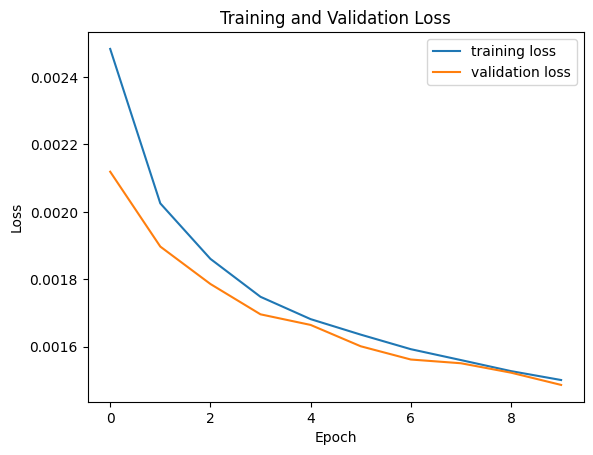

In [ ]:
import matplotlib.pyplot as plt
# plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create Keys

In [ ]:
#create keys for unique rows

df['key'] = df.groupby(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app']).ngroup()

In [ ]:
#latex

latex_table = df.head().style.to_latex()

# print latex table
print(latex_table)

\begin{tabular}{lrllllllr}
 & latency & requestSize & requestMethod & responseSize & requestUrl & status & source_app & key \\
timestamp &  &  &  &  &  &  &  &  \\
2023-04-15 08:26:58.215025 UTC & 1 & 730 & POST & 1757 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 231 \\
2023-04-15 08:26:58.216662 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.354216 UTC & 1 & 730 & POST & 1747 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 229 \\
2023-04-15 08:26:58.356309 UTC & 1 & 730 & POST & 1695 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 217 \\
2023-04-15 08:26:58.361683 UTC & 1 & 730 & POST & 1742 & http://productcatalogservice:3550/hipstershop.ProductCatalogService/GetProduct & 200 & frontend & 227 \\
\end{tabular}



In [ ]:
df=df[['key']]

df = pd.get_dummies(df, columns=['key'])

In [ ]:
df.head()

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,key_377,key_378,key_379,key_380,key_381,key_382,key_383,key_384,key_385,key_386
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-15 08:26:58.215025 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.216662 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.354216 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.356309 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-15 08:26:58.361683 UTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler


train_size = int(len(df) * 0.95)
train = df[:train_size][df.columns]
test = df[train_size:][df.columns]

In [ ]:
np.argpartition(X[0][0],-1)[-1]

110

In [ ]:
np.argpartition(yhat[0][0],-5)[-5:]

array([ 58,  68, 113,  32,  76])

In [ ]:
#reconstruction cost for the test set


mse = np.mean(np.mean(np.power(X - yhat, 2), axis=1),axis=1)
mse

array([0.00485279, 0.00451607, 0.00409346, ..., 0.00446442, 0.00524236,
       0.00528777], dtype=float32)

# legacy

## timeseries testing

In [ ]:
# fit model
model.fit(X, X, epochs=5, batch_size=5, verbose=2)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

Epoch 1/5
998/998 - 41s - loss: 0.0049 - 41s/epoch - 41ms/step
Epoch 2/5
998/998 - 32s - loss: 0.0043 - 32s/epoch - 32ms/step
Epoch 3/5
998/998 - 32s - loss: 0.0039 - 32s/epoch - 32ms/step
Epoch 4/5
998/998 - 32s - loss: 0.0037 - 32s/epoch - 32ms/step
Epoch 5/5
998/998 - 33s - loss: 0.0035 - 33s/epoch - 33ms/step
---Predicted---
[[[-0.     0.005  0.008 ...  0.001  0.003  0.001]
  [-0.     0.007  0.014 ...  0.001  0.004  0.002]
  [ 0.     0.006  0.015 ...  0.     0.003  0.002]
  ...
  [ 0.007  0.006  0.006 ...  0.003 -0.001 -0.002]
  [ 0.006  0.011  0.008 ...  0.003  0.001 -0.003]
  [ 0.005  0.017  0.012 ...  0.004  0.004 -0.004]]

 [[ 0.     0.006  0.006 ...  0.001  0.003  0.   ]
  [ 0.     0.01   0.012 ...  0.001  0.004  0.002]
  [ 0.     0.01   0.015 ... -0.001  0.004  0.003]
  ...
  [ 0.005  0.01   0.01  ...  0.002  0.    -0.002]
  [ 0.006  0.013  0.011 ...  0.002  0.002 -0.002]
  [ 0.006  0.015  0.012 ...  0.002  0.004 -0.002]]

 [[ 0.001  0.008  0.008 ...  0.001  0.003  0.   ]
  [

In [ ]:
# bug fixing test piece

import os
import json
import pandas as pd

data = []


# Load the JSON file
with open("train/data-000000000021") as f:
# Extract the relevant features from each log entry
    for line in f:
        entry = json.loads(line)
        # Extract the relevant features from the entry and add them to the data list
        features = {'latency': entry['httpRequest']['latency'],
                    'requestSize': entry['httpRequest']['requestSize'],
                    'requestMethod': entry['httpRequest']['requestMethod'],
                    'responseSize': entry['httpRequest']['responseSize'],
                    'requestUrl': entry['httpRequest']['requestUrl'],
                    'status': entry['httpRequest']['status'],
                    'source_app': entry['labels']['source_app'],
                    'timestamp': entry['timestamp']}
        data.append(features)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)
df.head

In [ ]:
folder_path = './train'  # change this to your folder path
data = []
errors = 0

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    if ("data" not in filename):
        continue
    file_path = os.path.join(folder_path, filename)
    # Load the JSON file
    with open(file_path) as f:
        # Extract the relevant features from each log entry
        for line in f:
            try:
                entry = json.loads(line)
                # Extract the relevant features from the entry and add them to the data list
                features = {'latency': entry['httpRequest']['latency'],
                            'requestSize': entry['httpRequest']['requestSize'],
                            'requestMethod': entry['httpRequest']['requestMethod'],
                            'responseSize': entry['httpRequest']['responseSize'],
                            'requestUrl': entry['httpRequest']['requestUrl'],
                            'status': entry['httpRequest']['status'],
                            'source_app': entry['labels']['source_app'],
                            'timestamp': entry['timestamp']}
                data.append(features)
            except json.JSONDecodeError:
                # Handle JSONDecodeError and continue to the next line
                errors += 1
                # print(f"Error decoding JSON in file {file_path}: {line}")
                continue

# Convert the list of dictionaries into a DataFrame
print("Number of errors: " + str(errors))
df = pd.DataFrame(data)
df.head()

Number of errors: 18


,latency,requestSize,requestMethod,responseSize,requestUrl,status,source_app,timestamp
0,0.001479,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.235081 UTC
1,0.002243,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:27.826092 UTC
2,0.001678,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:29.543643 UTC
3,0.001477,717,POST,1626,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:32.243186 UTC
4,0.001591,712,POST,1778,http://currencyservice:7000/hipstershop.Curren...,200,frontend,2023-04-15 09:29:31.537701 UTC


In [ ]:
#OLD


import json
import pandas as pd


# Load data from JSON file and Convert data to pandas DataFrame
df = pd.read_json('data.json', convert_dates=['timestamp'])


In [ ]:
import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X.shape[1], X.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')

IndexError: tuple index out of range

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

# Convert categorical features to one-hot encoded format
#df = pd.get_dummies(df, columns=['requestUrl', 'status', 'source_app','requestMethod'])

# Normalize the numerical features
#scaler = MinMaxScaler()
#df[["latency", "requestSize", "responseSize"]] = scaler.fit_transform(df[["latency", "requestSize", "responseSize"]])
#df.columns.values.astype(list)

array(['latency', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dtype=object)

In [ ]:

test_array = np.array(test)
test_array = np.reshape(test_array, (test_array.shape[0], 1, test_array.shape[1]))

# Generate predictions on test data
y_pred = model.predict(test_array)

# Denormalize the predicted values
y_pred_denorm = scaler.inverse_transform(y_pred)

# Calculate the mean squared error
mse = np.mean(np.square(test - y_pred_denorm))

print('Test MSE:', mse)


8/8 [==============================] - 1s 3ms/step
Test MSE: latency                                                                                               0.011552
requestSize                                                                                           0.003098
responseSize                                                                                          0.053303
requestUrl_http://adservice:9555/hipstershop.AdService/GetAds                                         0.063806
requestUrl_http://cartservice:7070/hipstershop.CartService/AddItem                                    0.007903
requestUrl_http://cartservice:7070/hipstershop.CartService/EmptyCart                                  0.000008
requestUrl_http://cartservice:7070/hipstershop.CartService/GetCart                                    0.080683
requestUrl_http://checkoutservice:5050/hipstershop.CheckoutService/PlaceOrder                         0.000004
requestUrl_http://currencyservice:7000/hipstershop.

/opt/software/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
